In [1]:
import numpy as np
import pandas as pd
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Data, Current, Learner,Simulator
import os
import matplotlib.pyplot as plt

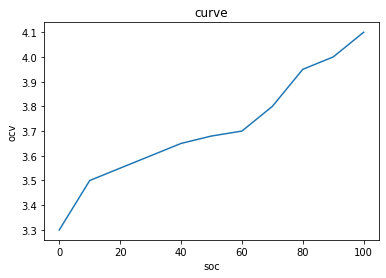

In [2]:
ocv = [3.3, 3.5, 3.55, 3.6, 3.65, 3.68, 3.70, 3.8, 3.95, 4.0, 4.1]
soc = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

In [3]:
param = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": 15,
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}

m1 = EcmCell(name="cell_model1", parameters=param, curve=c1)
# m1.display()

In [4]:
dt = 0.1
CURR_EXCITATION = 7.5
HOUR = 3600.0
h_steps = [1.75, 0.25, 0.25, 0.25, 1, 1, 1]
current_steps = [
 -CURR_EXCITATION,
 -CURR_EXCITATION / 2,
 -CURR_EXCITATION / 4,
 -CURR_EXCITATION / 8,
 0.0,
 CURR_EXCITATION,
 0.0,
]

initial_soc = 0.0
t_steps = [value * HOUR for value in h_steps]
total_time = sum(t_steps)
samples = int(total_time / dt)

time_np = np.linspace(0.0, total_time, samples)
step_cur = Current(name="current1")

In [5]:
for t_step, current_step in zip(t_steps, current_steps):
 step_cur.add_step(current_step, int(t_step / dt))

data = {"time": time_np, "current": step_cur.current}
df = pd.DataFrame(data)
d1 = Data(name="current_excite", df=df)

In [6]:
s1 = Simulator(name="simulator1")
s1.attach(m1).attach(d1)

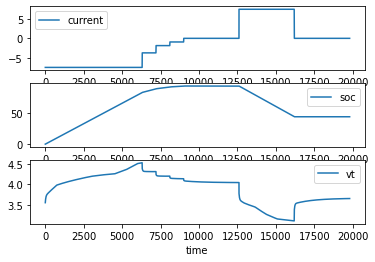

In [7]:
sol = s1.run(
    pair=("cell_model1", "current_excite"),
    x0=np.array([0, 0, initial_soc]),
    config={"solver_type": "adaptive", "solution_name": "sol1"},
)

sol.disp(["current", "soc", "vt"])

In [8]:
TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),'tests\CS2_3_9_28_11.csv')
schema = {
    "Test_Time(s)": "time",
    "Current(A)": "current",
    "Voltage(V)": "vt",
    "rsv_i_dir": True,
}
d1 = Data(name='d1', df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
# save the calculation time
# d1.df=d1.df[d1.df['time']>3000].reset_index()
d1.df

,Data_Point,time,Step_Time(s),Step_Index,Cycle_Index,current,vt,Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.015232,30.015232,1,1,-0.000000,4.173913,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0,0,0,0
1,2,30.015690,0.000003,2,1,-0.549755,4.228631,3.880000e-10,0.000000,1.640000e-09,0.000000,0.000000,0,0,0,0
2,3,30.016015,0.000002,3,1,-0.228993,4.199653,5.410000e-10,0.000000,2.290000e-09,0.000000,0.000000,0,0,0,0
3,4,40.031788,10.015776,3,1,-0.198651,4.199653,6.001620e-04,0.000000,2.520454e-03,0.000000,0.000000,0,0,0,0
4,5,50.032398,20.016385,3,1,-0.177339,4.199653,1.120349e-03,0.000000,4.705045e-03,0.000000,0.000032,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11147,11148,113634.147000,1231.878194,30,1,2.200021,3.058521,5.288141e+00,6.039510,2.102755e+01,22.359978,-0.005083,0,0,0,0
11148,11149,113644.162400,1241.893589,30,1,2.200021,2.978063,5.288141e+00,6.045630,2.102755e+01,22.378464,-0.007026,0,0,0,0
11149,11150,113654.177900,1251.909034,30,1,2.199840,2.870571,5.288141e+00,6.051751,2.102755e+01,22.396377,-0.009292,0,0,0,0
11150,11151,113664.193200,1261.924408,30,1,2.199840,2.746243,5.288141e+00,6.057871,2.102755e+01,22.413567,-0.009907,0,0,0,0


In [9]:

# l1=Learner(name="l1")
# # initial guess for R0, R1,C1,R2,C2
# p0=[0.1,
# 0.005,
# 1500,
# 0.04,
# 65000]
# x0=np.array([0, 0, 100])
# config={"solver_type": None, "solution_name": "sol1"}
# res=l1.fit_parameters(p0,d1,c1,config,x0,"ls")
# R0,R1,C1,R2,C2=res.x
# print("R0:",R0,"R1:",res.x[1],"C1:",res.x[2],"R2:",res.x[3],"C2:",res.x[4])


In [10]:
param_sim = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": d1.df['Discharge_Capacity(Ah)'].max(),
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}
m_sim = EcmCell(name="cell_model_sim", parameters=param_sim, curve=c1)
s2=Simulator(name="s2")
s2.attach(d1).attach(m_sim)
l2=Learner(name="l2")
l2.attach(s2)
m_d_s=('cell_model_sim','d1','s2')
x0_sim=np.array([0, 0, 100])
config={"solver_type": None, "solution_name": "sol1"}
method="global"
res=l2.fit_parameters(m_d_s,config,x0_sim,method)

rmse 0.22796167802895484 11152 11152
rmse 0.16198401853835273 11152 11152
rmse 0.19110736039776896 11152 11152
rmse 0.13738012353786536 11152 11152
rmse 0.17989557684926727 11152 11152
rmse 0.15703858867148018 11152 11152
rmse 0.14126053848541742 11152 11152
rmse 0.17480950562086126 11152 11152
rmse 0.20415362377007293 11152 11152
rmse 0.1328911422453465 11152 11152
rmse 0.13291986585528334 11152 11152
rmse 0.13939422861720654 11152 11152
rmse 0.14637548217735888 11152 11152
rmse 0.14853355972460217 11152 11152
rmse 0.1782681704112444 11152 11152
rmse 0.13844765655195462 11152 11152
rmse 0.18220126896499964 11152 11152
rmse 0.7053698126436078 11152 11152
rmse 0.15494894223082945 11152 11152
rmse 0.19040267650266593 11152 11152
rmse 0.5035941586995056 11152 11152
rmse 0.10633843505834291 11152 11152
rmse 0.1689529459482978 11152 11152
rmse 0.19062068967565038 11152 11152
rmse 0.16026499648496675 11152 11152
rmse 0.16189932526524584 11152 11152
rmse 0.165856237881554 11152 11152
rmse 0.2

In [11]:
# d1.df['Charge_Capacity(Ah)'].max()
# d1.df['Discharge_Capacity(Ah)'].max()
res.x

array([1.94985703e-01, 9.56519217e+00, 1.28167400e+04, 5.19333260e+00,
       2.58200475e+04])

In [12]:
d2=s2.get("sol1")
d1.df.vt.min()
# d2.df.current.iloc[11104]

2.699781895

In [13]:
# res=l1.run_sim(p0,d1.get_current,d1.df.time,c1,config,x0)
# len(res[0])
# plt.plot(d1.df.vt,'.',label="true")
# plt.plot(res[0],'.',label="pred")
# plt.legend()

rmse: 0.08404423810748866 r square: 0.8623188260918194


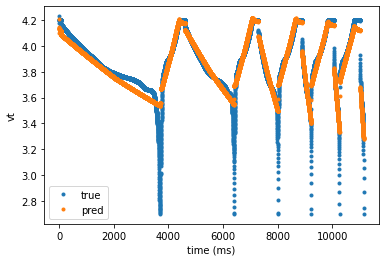

In [14]:
from sklearn.metrics import mean_squared_error,r2_score
d2=s2.get("sol1")
y_true=d1.df.vt
y_pred=d2.df.vt

rmse=mean_squared_error(y_true, y_pred, squared=False)
r_square=r2_score(y_true, y_pred)
print('rmse:',rmse,"r square:",r_square)

plt.plot(y_true,'.',label="true")
plt.plot(y_pred,'.',label="pred")

plt.xlabel('time (ms)')
plt.ylabel('vt')
plt.legend()
plt.show()

,time,current
3678,37124.66371,0.110191
3679,37124.71298,-0.000000


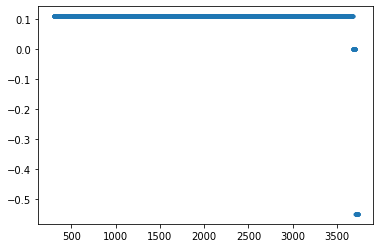

In [15]:
plt.plot(d1.df.current.iloc[300:3740],'.',label="curr")
d2.df.time.iloc[3679]-d2.df.time.iloc[3678]
d1.df[['time','current']].iloc[3678:3680]
# d1.df.time

In [16]:
d1.df.time.iloc[100:4000].diff().idxmax()
d1.df.time.iloc[3700:4000].diff()
# d2.df[['time','current','vt']].iloc[3650:3710]

3700         NaN
3701    14.96845
3702    16.32773
3703    17.78293
3704    19.32563
          ...   
3995    10.01539
3996    10.01540
3997    10.01554
3998    10.01527
3999    10.01540
Name: time, Length: 300, dtype: float64

In [17]:
res

     fun: 0.08404423810748887
     jac: array([-5.88418203e-07, -2.58265610e-06, -7.21586969e-08,  3.58185705e-06,
       -2.08150087e-08])
 message: 'Optimization terminated successfully.'
    nfev: 1578
     nit: 19
 success: True
       x: array([1.94985703e-01, 9.56519217e+00, 1.28167400e+04, 5.19333260e+00,
       2.58200475e+04])